<a href="https://colab.research.google.com/github/behnaznikkhah/Project/blob/master/LSTM_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate
from math import sqrt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import LeakyReLU
import numpy



In [14]:
#load datasets
file_path_covid= os.path.abspath("")
file_path_market = os.path.abspath("")

Covid = pd.read_csv(os.path.join(file_path_covid, 'Covid.csv'))
Market = pd.read_csv(os.path.join(file_path_market, 'Market.csv'))

#make a copy of covid dataset 
CovidData = Covid

#Impute missing values with the next valid observation 
CovidData=CovidData.fillna(method='bfill')

#cumalative cases and deaths
CovidData=CovidData[CovidData.Country.eq('World')]

#make a copy of markets data
MarketData = Market

#get the name of unique countries
country_list = MarketData.Country.unique().tolist()
numbers_list = []
countries_dict = {}

for i in range(1, 14):
    numbers_list.append(i)

for key in numbers_list:
    for value in country_list:
        countries_dict[key] = value 
        country_list.remove(value)
        break
    
print("Below is the list of countries for which you can classify stock market trends using corona virus headlines: ")
for key, value in countries_dict.items():
    print(key, value, sep=' -> ')

option = int(input("Enter the number of the country from above list: "))
country = countries_dict.get(option)
print("The country entered is: ", country)

MarketData=MarketData[MarketData.Country.eq(country)]

#drop all columns except Date and Price 
MarketData = MarketData.drop(['Volume','Low','Open','Change','High','Country'], 1)

#create a differenced column named cases_diff, shows the number of new active cases in each day 
CovidData['cases_diff'] = CovidData['ActiveCases'].diff()

#create a differenced column named deaths_diff, shows the number of deaths in each day 
CovidData['deaths_diff'] = CovidData['Deaths'].diff()

#drop columns
CovidData = CovidData.drop(['ActiveCases','Deaths','Country'], 1)

#join two dataset
result = pd.merge(CovidData, MarketData, how='inner', on=['Date'])

#change the order of columns
result=result[['Date','Price','cases_diff','deaths_diff']]



Below is the list of countries for which you can classify stock market trends using corona virus headlines: 
1 -> United Arab Emirates
2 -> Brazil
3 -> France
4 -> Germany
5 -> United States
6 -> Indonesia
7 -> South Korea
8 -> India
9 -> Japan
10 -> Australia
11 -> Canada
12 -> China
13 -> South Africa
Enter the number of the country from above list: 1
The country entered is:  United Arab Emirates


In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [17]:
# load dataset
dataset = result

#set Date column as Index
dataset=dataset.set_index('Date')

# ensure all data is float
values = dataset.values
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 30,1)


#exclude the previous value of Index price
lst = [x for x in range(0, 90) if x % 3 == 0]
reframed.drop(reframed.columns[lst], axis=1, inplace=True)


# drop columns we don't want to predict
reframed.drop(reframed.columns[[61,62]], axis=1, inplace=True)

# normalize features
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [18]:
# split into train and test sets
n_train = 150
train = scaled[:n_train, :]
test = scaled[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,scaled.shape)

(150, 1, 60) (150,) (43, 1, 60) (43,) (193, 61)


In [19]:
#design a LSTM network
def lstm_model (activation,optimizer):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  np.random.seed(0)
  tf.keras.backend.clear_session()

  model = Sequential()
  model.add(LSTM(50,activation=activation, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(LSTM(10,activation=activation))
  model.add(Dense(1,activation=activation))
  model.compile(loss='mse', optimizer = optimizer,metrics=["mae"])
  return model
  


In [20]:
#fit LSTM network for each country
if country=='United Arab Emirates':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4))
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country=='Brazil':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 200,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country=='France':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4))
  history=model.fit(train_X, train_y, epochs = 80,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country == 'Germany':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 200,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country=='Hong Kong':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4))
  history=model.fit(train_X, train_y, epochs = 60,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country == 'Indonesia':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 150,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country == 'South Korea':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 150,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='United States':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 150,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='India':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 80,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='Japan':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4))
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='Asutralia':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer ='adam')
  history=model.fit(train_X, train_y, epochs = 30,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='Canada':
  model=lstm_model(activation='sigmoid',optimizer ='adam')
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='China':
  model=lstm_model(activation='sigmoid',optimizer =tf.keras.optimizers.Adam(learning_rate=5e-4))
  history=model.fit(train_X, train_y, epochs = 150,batch_size=1, validation_data=(test_X, test_y), verbose=0)
elif country =='South Africa':
  model=lstm_model(activation=tf.keras.layers.LeakyReLU( ),optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4))
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)
else:
  print("sth wrong happened")



In [ ]:

#design a RNN network
def RNN_model (activation,optimizer):

    model = Sequential()
    model.add(tf.keras.layers.SimpleRNN(50, return_sequences=True,input_shape = (train_X.shape[1], train_X.shape[2]), activation = activation))
    model.add(tf.keras.layers.SimpleRNN(10, activation = activation))
    model.add(Dense(1, activation = activation))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
if country =='Canada':
  model=RNN_model(activation='sigmoid',optimizer ='adam')
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)


In [ ]:
#design a MLP network
def MLP_model (activation,optimizer):

    model = Sequential()
    model.add(Dense(50,input_shape = (train_X.shape[1], train_X.shape[2]), activation=activation))
    model.add(Dense(10, activation=activation))
    model.add(Dense(1,activation=activation))

    # Compile the model with the optimizer, loss, and metrics
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
if country =='Canada':
  model=MLP_model(activation='sigmoid',optimizer ='adam')
  history=model.fit(train_X, train_y, epochs = 100,batch_size=1, validation_data=(test_X, test_y), verbose=0)


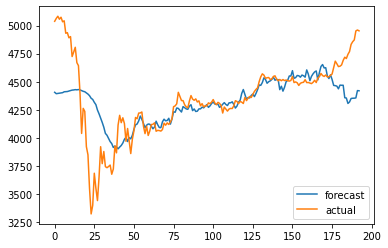

In [23]:
#forecast the entire training dataset to build up state for forecasting
model.predict(train_X, batch_size=1)

#make a one-step forecast
forecast = []
for time in range(len(scaled)):
        X=scaled[time:time+1][:,:-1]
        X = X.reshape((1, 1, 60))
        yhat = model.predict(X)
        new_X=scaled[time, 0:-1]
        yhat_invert = invert_scale(scaler, new_X, yhat[0,0])
        forecast.append(yhat_invert)

plt.plot(forecast,label='forecast')
plt.plot(values[:,:][:,-1],label='actual')
plt.legend()
plt.show()


2/2 [==============================] - 0s 3ms/step - loss: 0.0202 - mae: 0.0998
Final loss value: [0.020236749202013016, 0.09981637448072433]


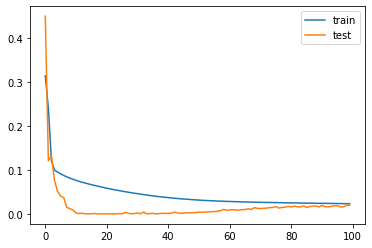

In [24]:
# Evaluate the model 
print("Final loss value:",model.evaluate(test_X, test_y))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
# calculate MAE
print(tf.keras.metrics.mean_absolute_error(values[:,-1], forecast).numpy())

# calculate RMSE
rmse = sqrt(mean_squared_error(values[:,-1], forecast))
print('Test RMSE: %.3f' % rmse)

160.06183
Test RMSE: 265.401
